In [1]:
import imp
import os
import sys
from os.path import join
from pycog.utils import mkdir_p
import numpy as np

name = 'rdm_dense'

base = os.path.abspath(os.getcwd())
examplespath = join(base, 'examples')
modelspath = join(examplespath, 'models')
analysispath = join(examplespath, 'analysis')
workpath = join(base, name)
datapath = join(workpath, 'data')
figspath = join(workpath, 'figs')
trialspath = join(workpath, 'trials')

for path in [datapath, figspath, trialspath]:
    mkdir_p(path)


# Select which model file to use here.
modelfile = join(modelspath, name + '.py')
# Select the corresponding analysis script here.
runfile = join(analysispath, 'rdm.py')

# Set the data file name here
savefile = join(datapath, name + '.pkl')


In [3]:
############
# Training #
############

from pycog import Model
seed = 1001
model = Model(modelfile=modelfile)

# Only train the models once, then you can just load them
recover = True 

model.train(savefile, seed=seed, recover=recover)

=> settings
   | GPU:                       no
   | init seed:                 1001
   | distribution (Win):        uniform
   | distribution (Wrec):       gamma
   | distribution (Wout):       uniform
   | Nin/N/Nout:                2/100/2
   | Dale's law:                E/I = 80/20
   | initial spectral radius:   1.50
   | train recurrent bias:      no
   | train output bias:         no
   | train initial conditions:  yes
   | sparseness (Wrec):         p = 0.99, p_plastic = 0.99
   | sparseness (Wout):         p = 0.80, p_plastic = 0.80
   | E/I positivity function:   rectify
   | hidden activation:         rectify
   | output activation/loss:    linear/squared
   | mode:                      batch
   | output mask:               yes
   | sigma_in:                  0.01
   | sigma_rec:                 0.15
   | rectify inputs:            True
   | gradient minibatch size:   20
   | validation minibatch size: 1100
   | dt:                        20.0 ms
   | tau:                    

In [4]:
#############
# RNN setup #
#############

# Get the analysis and model files as modules.
r = imp.load_source('analysis', runfile)
m = imp.load_source('model', modelfile)

# Set all the parameters.

dt = 0.5 # Default value
dt_save = 20 # From all.py

action = 'trials'
num_trials = 50
args = [num_trials]
antagonist_level = 0

params = {
        'seed':       seed,
        'model':      m,
        'savefile':   savefile,
        'name':       name,
        'datapath':   datapath,
        'figspath':   figspath,
        'trialspath': trialspath,
        'dt':         dt,
        'dt_save':    dt_save,
        'ant_level':  antagonist_level
        }

In [8]:
dir(m)


['Cout',
 'EXC',
 'INH',
 'N',
 'Nin',
 'Nout',
 'SCALE',
 'TARGET_PERFORMANCE',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'cohs',
 'division',
 'ei',
 'generate_trial',
 'in_outs',
 'n_validation',
 'nconditions',
 'np',
 'pcatch',
 'performance',
 'scale',
 'tasktools',
 'terminate']

In [10]:
###############
# Run the RNN #
###############

ant_levels = [0, .1, .2, .3, .4, .5, .6]
#for ant_level in ant_levels:
#    params['ant_level'] = ant_level
#    r.do(action, args, params)

[ examples.analysis.rdm.chronometric_function ] 304/550 trials did not reach threshold.


AttributeError: 'NoneType' object has no attribute 'hist'

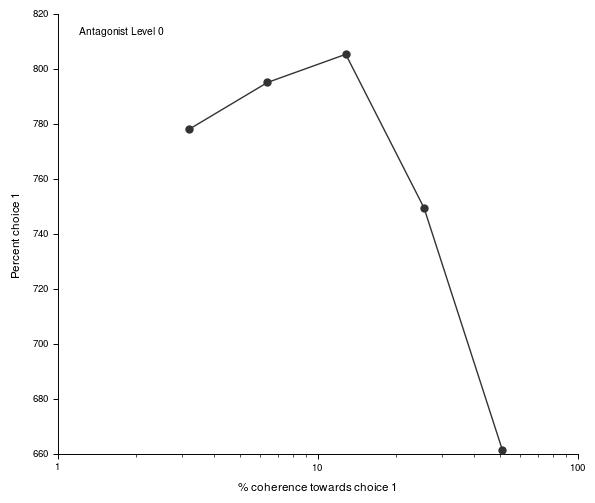

In [12]:
%matplotlib inline
from pycog.figtools import Figure

############################
# Plot psychometric curves #
############################

for ant_level in ant_levels:
    trialsfile = join(trialspath, name + '_ant_level_' + 
                      str(ant_level) + '_trials.pkl')
    fig = Figure()
    plot = fig.add()
    plot.xlabel(r'\% coherence towards choice 1')
    plot.ylabel(r'Percent choice 1')
    plot.text_upper_left('Antagonist Level {}'.format(str(ant_level)))
    r.chronometric_function(trialsfile, plot=plot)
    


[ pycog.rnn.RNN ] 11000 updates, best error = 0.19368601, spectral radius = 2.25614095
[ pycog.rnn.RNN ] 11000 updates, best error = 0.19368601, spectral radius = 2.25614095
[ pycog.rnn.RNN ] 11000 updates, best error = 0.19368601, spectral radius = 2.25614095
[ pycog.rnn.RNN ] 11000 updates, best error = 0.19368601, spectral radius = 2.25614095
[ pycog.rnn.RNN ] 11000 updates, best error = 0.19368601, spectral radius = 2.25614095
[ pycog.rnn.RNN ] 11000 updates, best error = 0.19368601, spectral radius = 2.25614095
[ pycog.rnn.RNN ] 11000 updates, best error = 0.19368601, spectral radius = 2.25614095


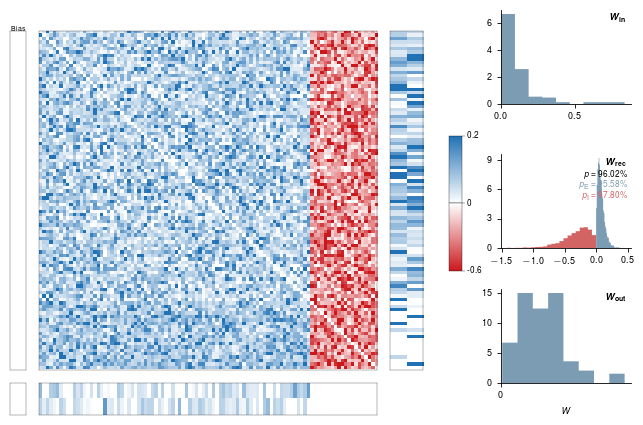

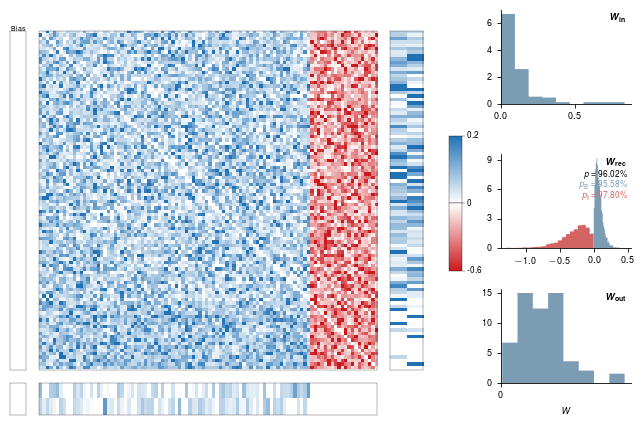

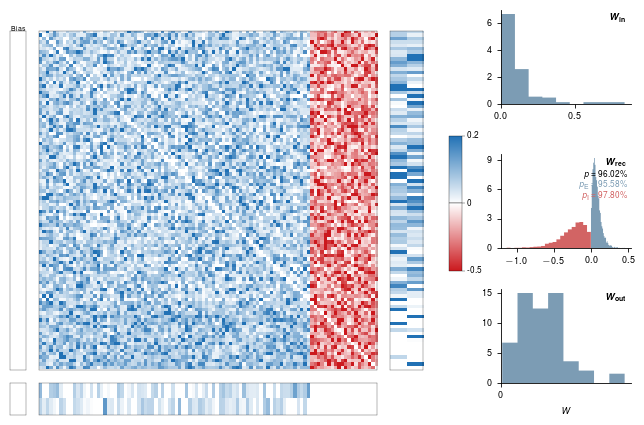

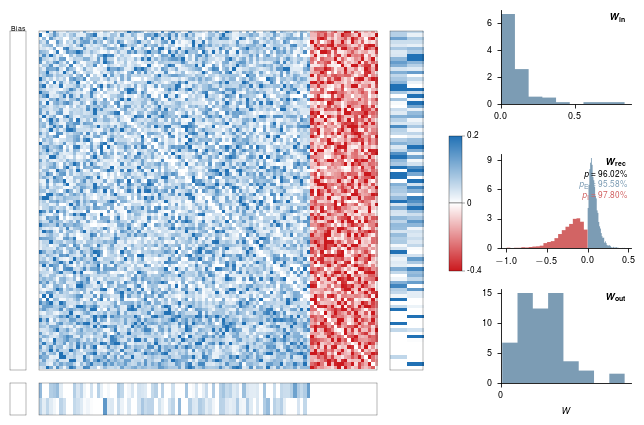

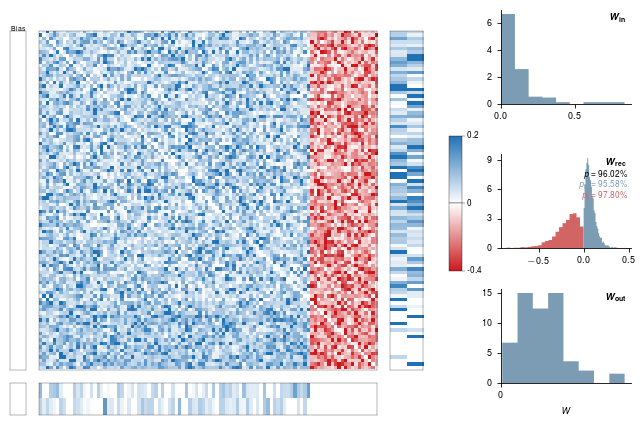

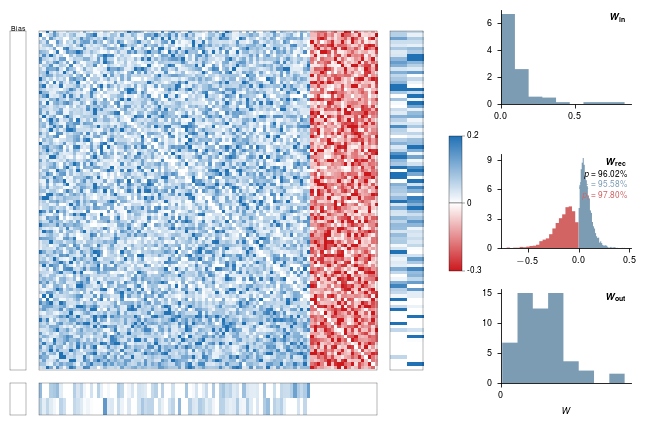

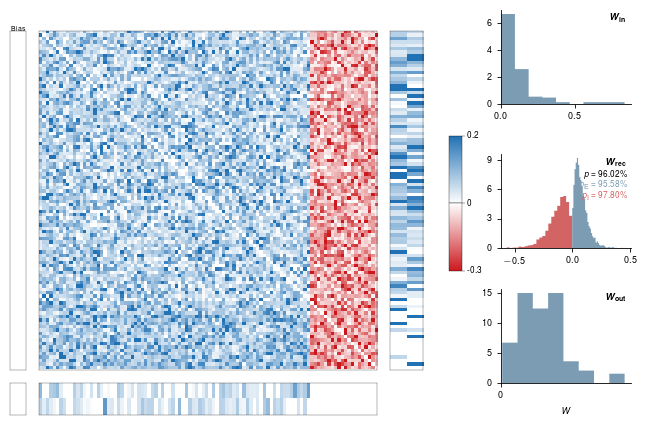

In [6]:
from pycog.rnn import RNN

######################
# Plot RNN Structure #
######################

for ant_level in ant_levels:
    rnn = RNN(params['savefile'], {'dt': params['dt']}, verbose=False)
    rnn.Wrec[np.where(rnn.Wrec<0)] *= (1-ant_level)
    rnn.plot_structure()    
    

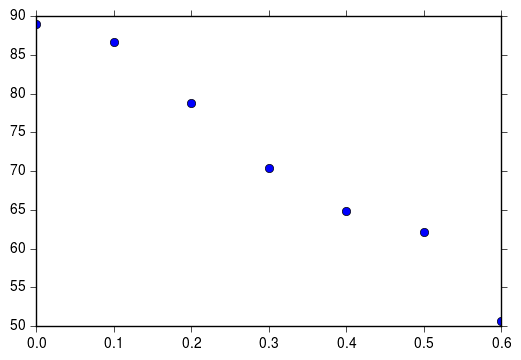

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

pc = [89, 86.6, 78.8, 70.4, 64.8, 62.2, 50.6]
plt.plot(ant_levels, pc, 'o')


In [10]:
############
# Training #
############

from pycog import Model
seed = 1001
model = Model(modelfile=modelfile)

# Only train the models once, then you can just load them
#recover = True 

#model.train(savefile, seed=seed, recover=recover)

AttributeError: 'module' object has no attribute 'C_rec'